## Imports and Load GTFS data

In [ ]:
!pip install folium shapely geopandas gtfs-kit

In [ ]:
!pip install -U kaleido

In [ ]:
import os
from os import path
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import folium
from shapely.geometry import LineString, Point
from folium.plugins import MarkerCluster, HeatMap
from folium import Marker, Icon, Circle, CircleMarker, GeoJson, PolyLine, Map
from geopy.distance import geodesic

In [ ]:
import json

In [ ]:
import gtfs_kit as gk

In [ ]:
path = Path('/content/gtfs-nyc-2023.zip')

In [ ]:
feed = gk.read_feed(path, dist_units='km')

In [ ]:
gtfs_validation = feed.validate()
gtfs_validation

,type,message,table,rows
2,error,Invalid arrival_time; maybe has extra space ch...,stop_times,"[106816, 106817, 106818, 106819, 106820, 10682..."
3,error,Invalid departure_time; maybe has extra space ...,stop_times,"[106816, 106817, 106818, 106819, 106820, 10682..."
0,warning,Feed expired,calendar/calendar_dates,[]
1,warning,Route has no trips,routes,"[28, 36, 63, 68]"
4,warning,"Repeated pair (trip_id, departure_time)",stop_times,"[108932, 108957, 108982, 109007, 109032, 10905..."


In [ ]:
gtfs_validation['num_rows'] = gtfs_validation['rows'].apply(lambda x: len(x))
gtfs_validation

,type,message,table,rows,num_rows
2,error,Invalid arrival_time; maybe has extra space ch...,stop_times,"[106816, 106817, 106818, 106819, 106820, 10682...",57135
3,error,Invalid departure_time; maybe has extra space ...,stop_times,"[106816, 106817, 106818, 106819, 106820, 10682...",57134
0,warning,Feed expired,calendar/calendar_dates,[],0
1,warning,Route has no trips,routes,"[28, 36, 63, 68]",4
4,warning,"Repeated pair (trip_id, departure_time)",stop_times,"[108932, 108957, 108982, 109007, 109032, 10905...",35


In [ ]:
stop_times = feed.stop_times.copy()
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,1619710,16:30:00,16:30:00,12493,1,NaN,0,0,NaN,1
1,1619710,16:31:40,16:31:40,12052,2,NaN,0,0,0.4553,0
2,1619710,16:32:35,16:32:35,12053,3,NaN,0,0,0.7063,0
3,1619710,16:33:18,16:33:18,18002,4,NaN,0,0,0.9035,0
4,1619710,16:33:46,16:33:46,12055,5,NaN,0,0,1.0303,0


In [ ]:
stop_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229928 entries, 0 to 229927
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              229928 non-null  object 
 1   arrival_time         229928 non-null  object 
 2   departure_time       229928 non-null  object 
 3   stop_id              229928 non-null  object 
 4   stop_sequence        229928 non-null  int64  
 5   stop_headsign        0 non-null       object 
 6   pickup_type          229928 non-null  int64  
 7   drop_off_type        229928 non-null  int64  
 8   shape_dist_traveled  221935 non-null  float64
 9   timepoint            229928 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 17.5+ MB


In [ ]:
stop_times.isnull().sum()

,0
trip_id,0
arrival_time,0
departure_time,0
stop_id,0
stop_sequence,0
stop_headsign,229928
pickup_type,0
drop_off_type,0
shape_dist_traveled,7993
timepoint,0


In [ ]:
# Checking Arrival Time and Departure Time
num_of_invalid_AT = stop_times['arrival_time'].str.contains(' ').sum()
print(f"Percentage of Data of Arrival Time containing Spaces: {(num_of_invalid_AT / len(stop_times) * 100):.2f}%")

num_of_invalid_DT = stop_times['departure_time'].str.contains(' ').sum()
print(f"Percentage of Data of Departure Time containing Spaces: {(num_of_invalid_DT / len(stop_times) * 100):.2f}%")

Percentage of Data of Arrival Time containing Spaces: 24.85%
Percentage of Data of Departure Time containing Spaces: 24.85%


In [ ]:
# Removing the space from the Arrival and Departure Time
stop_times['arrival_time'] = stop_times['arrival_time'].str.replace(' ', '')
stop_times['departure_time'] = stop_times['departure_time'].str.replace(' ', '')

In [ ]:
# Checking Arrival and Departure TIme Containing Null Values
arrival_time_missing_values = stop_times['arrival_time'].apply(lambda x: np.nan if x == '' else x).isnull().sum()
print(f"Percentage of Data of Arrival Time containing Null Values: {(arrival_time_missing_values / len(stop_times) * 100).round(2)}%")

departure_time_missing_values = stop_times['departure_time'].apply(lambda x: np.nan if x == '' else x).isnull().sum()
print(f"Percentage of Data of Departure Time containing Null Values: {(departure_time_missing_values / len(stop_times) * 100).round(2)}%")

Percentage of Data of Arrival Time containing Null Values: 0.0%
Percentage of Data of Departure Time containing Null Values: 0.0%


In [ ]:
stop_times.duplicated().sum()

0

In [ ]:
feed.stop_times = stop_times

In [ ]:
feed.routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,19627,Centro,Aub 1,West Genesee,NaN,3,NaN,38A848,FFFFFF
1,19628,Centro,Aub 2,Franklin,NaN,3,NaN,3C62AE,FFFFFF
2,19629,Centro,Aub 3,North Street,NaN,3,NaN,7E3092,FFFFFF
3,19630,Centro,Aub 4,State Street,NaN,3,NaN,D98C27,FFFFFF
4,19631,Centro,Aub 6,Wegmans Shoppers,NaN,3,NaN,00FF00,FFFFFF


In [ ]:
routes_with_no_trips = []
for idx, row in feed.routes.iterrows():
    if len(feed.trips[feed.trips['route_id'] == row['route_id']]) == 0:
        routes_with_no_trips.append(row['route_id'])
        print(idx)

28
36
63
68


In [ ]:
routes_with_no_trips

['19685', '19693', '19720', '19725']

In [ ]:
# Removing all the routes with no trips i.e. routes_with_no_trips
feed.routes = feed.routes[~feed.routes['route_id'].isin(routes_with_no_trips)]

In [ ]:
feed.validate()

,type,message,table,rows
0,warning,Feed expired,calendar/calendar_dates,[]
1,warning,"Repeated pair (trip_id, departure_time)",stop_times,"[108932, 108957, 108982, 109007, 109032, 10905..."


In [ ]:
feed.trips.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,19627,1,1619723,1 West Genesee - Mercy Rehab.,NaN,0,255320,138172,0,0
1,19627,1,1619722,1 West Genesee - Tops Market,NaN,0,255321,138170,0,0
2,19627,1,1619721,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0
3,19627,1,1619720,1 West Genesee - Fingerlakes Mall,NaN,0,255319,138169,0,0
4,19627,1,1619719,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0


In [ ]:
feed.stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,17,17,Thurber St & Alden St,NaN,43.018504,-76.133335,NaN,NaN,NaN,NaN,NaN,0
1,22,22,Thompson Rd & Springfield Rd,SPRINGFIELD RD,43.051660,-76.080436,NaN,NaN,NaN,NaN,NaN,0
2,28,28,Bishop Grimes,NaN,43.077158,-76.060720,NaN,NaN,NaN,NaN,NaN,0
3,47,47,Regional Transportation Center,NaN,43.076641,-76.169373,NaN,NaN,NaN,NaN,NaN,0
4,50,50,Loretto Rest,NaN,43.004997,-76.135725,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
feed.calendar_dates.head()

,service_id,date,exception_type
0,177404,20230904,1
1,177204,20230904,1
2,4,20230904,1
3,1,20230904,2
4,51501,20230905,1


In [ ]:
gk.list_feed(path)

,file_name,file_size
0,agency.txt,183
1,calendar.txt,2175
2,calendar_dates.txt,37933
3,feed_info.txt,168
4,google.log,215438
5,routes.txt,5090
6,shapes.txt,6149794
7,stop_times.txt,11260379
8,stops.txt,383868
9,transfers.txt,25206


In [ ]:
# Columns of Routes, Shapes, Stop Times, Stops, Trips
print(feed.routes.columns)
print(feed.shapes.columns)
print(feed.stop_times.columns)
print(feed.stops.columns)
print(feed.trips.columns)

Index(['route_id', 'agency_id', 'route_short_name', 'route_long_name',
       'route_desc', 'route_type', 'route_url', 'route_color',
       'route_text_color'],
      dtype='object')
Index(['shape_id', 'shape_pt_lat', 'shape_pt_lon', 'shape_pt_sequence',
       'shape_dist_traveled'],
      dtype='object')
Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'stop_headsign', 'pickup_type', 'drop_off_type', 'shape_dist_traveled',
       'timepoint'],
      dtype='object')
Index(['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat',
       'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station',
       'stop_timezone', 'wheelchair_boarding'],
      dtype='object')
Index(['route_id', 'service_id', 'trip_id', 'trip_headsign', 'trip_short_name',
       'direction_id', 'block_id', 'shape_id', 'wheelchair_accessible',
       'bikes_allowed'],
      dtype='object')


In [ ]:
routes = feed.routes.copy()
shapes = feed.shapes.copy()
stop_times = feed.stop_times.copy()
stops = feed.stops.copy()
trips = feed.trips.copy()

In [ ]:
calendard_dates = feed.calendar_dates.copy()

## EDA

### Data Cleaning

#### **1. `routes` Data**

In [ ]:
# Data Cleaning for Routes
routes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 0 to 92
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   route_id          89 non-null     object
 1   agency_id         89 non-null     object
 2   route_short_name  89 non-null     object
 3   route_long_name   89 non-null     object
 4   route_desc        0 non-null      object
 5   route_type        89 non-null     int64 
 6   route_url         0 non-null      object
 7   route_color       89 non-null     object
 8   route_text_color  89 non-null     object
dtypes: int64(1), object(8)
memory usage: 7.0+ KB


In [ ]:
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,19627,Centro,Aub 1,West Genesee,NaN,3,NaN,38A848,FFFFFF
1,19628,Centro,Aub 2,Franklin,NaN,3,NaN,3C62AE,FFFFFF
2,19629,Centro,Aub 3,North Street,NaN,3,NaN,7E3092,FFFFFF
3,19630,Centro,Aub 4,State Street,NaN,3,NaN,D98C27,FFFFFF
4,19631,Centro,Aub 6,Wegmans Shoppers,NaN,3,NaN,00FF00,FFFFFF


In [ ]:
unique_routes = routes.route_id.nunique()
unique_routes

89

In [ ]:
routes.route_text_color.value_counts()

,count
route_text_color,
FFFFFF,72
000000,17


In [ ]:
routes_imp_features = ['route_id', 'route_long_name', 'route_type', 'route_color', 'route_text_color']
routes = routes[routes_imp_features]

#### **2. `shapes` Data**

In [ ]:
shapes.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,138169,42.932684,-76.566934,1,0.0000
1,138169,42.932532,-76.567233,2,0.0294
2,138169,42.931896,-76.568493,3,0.1539
3,138169,42.931846,-76.568571,4,0.1624
4,138169,42.931736,-76.568708,5,0.1787


In [ ]:
shapes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154088 entries, 0 to 154087
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   shape_id             154088 non-null  object 
 1   shape_pt_lat         154088 non-null  float64
 2   shape_pt_lon         154088 non-null  float64
 3   shape_pt_sequence    154088 non-null  int64  
 4   shape_dist_traveled  154088 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 5.9+ MB


In [ ]:
unique_shapes = shapes.shape_id.nunique()
print(f"Total number of shapes: {unique_shapes}")

Total number of shapes: 641


In [ ]:
# Sort the Shapes by shape_id followed by shape_pt_sequence
shapes = shapes.sort_values(by=['shape_id', 'shape_pt_sequence'])

#### **3. `stops` Data**

In [ ]:
stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,17,17,Thurber St & Alden St,NaN,43.018504,-76.133335,NaN,NaN,NaN,NaN,NaN,0
1,22,22,Thompson Rd & Springfield Rd,SPRINGFIELD RD,43.051660,-76.080436,NaN,NaN,NaN,NaN,NaN,0
2,28,28,Bishop Grimes,NaN,43.077158,-76.060720,NaN,NaN,NaN,NaN,NaN,0
3,47,47,Regional Transportation Center,NaN,43.076641,-76.169373,NaN,NaN,NaN,NaN,NaN,0
4,50,50,Loretto Rest,NaN,43.004997,-76.135725,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
unique_stops = stops.stop_id.nunique()
print(f"Total number of stops: {unique_stops}")

Total number of stops: 5724


In [ ]:
stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5724 entries, 0 to 5723
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stop_id              5724 non-null   object 
 1   stop_code            5724 non-null   object 
 2   stop_name            5724 non-null   object 
 3   stop_desc            386 non-null    object 
 4   stop_lat             5724 non-null   float64
 5   stop_lon             5724 non-null   float64
 6   zone_id              0 non-null      object 
 7   stop_url             0 non-null      object 
 8   location_type        0 non-null      float64
 9   parent_station       0 non-null      object 
 10  stop_timezone        0 non-null      object 
 11  wheelchair_boarding  5724 non-null   int64  
dtypes: float64(3), int64(1), object(8)
memory usage: 536.8+ KB


In [ ]:
stops.wheelchair_boarding.value_counts()

,count
wheelchair_boarding,
0,5724


In [ ]:
stops = stops[['stop_id', 'stop_code', 'stop_name', 'stop_lat', 'stop_lon']]

#### **4. `trips` Data**

In [ ]:
trips.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,19627,1,1619723,1 West Genesee - Mercy Rehab.,NaN,0,255320,138172,0,0
1,19627,1,1619722,1 West Genesee - Tops Market,NaN,0,255321,138170,0,0
2,19627,1,1619721,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0
3,19627,1,1619720,1 West Genesee - Fingerlakes Mall,NaN,0,255319,138169,0,0
4,19627,1,1619719,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0


In [ ]:
unique_trips = trips.trip_id.nunique()
print(f"Total number of trips: {unique_trips}")

Total number of trips: 7993


In [ ]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7993 entries, 0 to 7992
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   route_id               7993 non-null   object
 1   service_id             7993 non-null   object
 2   trip_id                7993 non-null   object
 3   trip_headsign          7993 non-null   object
 4   trip_short_name        0 non-null      object
 5   direction_id           7993 non-null   int64 
 6   block_id               7993 non-null   object
 7   shape_id               7993 non-null   object
 8   wheelchair_accessible  7993 non-null   int64 
 9   bikes_allowed          7993 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 624.6+ KB


In [ ]:
trips.trip_headsign.value_counts()

,count
trip_headsign,
582 Orange Lot,885
344 South Campus,435
344 South Campus - Skytop,431
909 Destiny USA PNR,285
782 Willis Ave,210
...,...
7252 Townsend St - Court St,1
7264 Townsend - W Onondaga,1
2176 Teall Ave - Salt Springs Rd,1


In [ ]:
total_services = trips.service_id.nunique()
print(f"Total number of services: {total_services}")

total_blocks = trips.block_id.nunique()
print(f"Total number of blocks: {total_blocks}")

total_routes = trips.route_id.nunique()
print(f"Total number of routes: {total_routes}")

total_shapes = trips.shape_id.nunique()
print(f"Total number of shapes: {total_shapes}")

Total number of services: 54
Total number of blocks: 742
Total number of routes: 89
Total number of shapes: 641


In [ ]:
trips.direction_id.value_counts()

,count
direction_id,
0,4743
1,3250


In [ ]:
trips.wheelchair_accessible.nunique()

1

In [ ]:
trips.bikes_allowed.nunique()

1

#### **5. `calendar_dates` Data**

In [ ]:
calendard_dates.head()

,service_id,date,exception_type
0,177404,20230904,1
1,177204,20230904,1
2,4,20230904,1
3,1,20230904,2
4,51501,20230905,1


In [ ]:
calendard_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   service_id      2101 non-null   object
 1   date            2101 non-null   object
 2   exception_type  2101 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 49.4+ KB


In [ ]:
unique_services = calendard_dates.service_id.nunique()
print(f"Total number of services: {unique_services}")

Total number of services: 41


In [ ]:
calendard_dates.groupby(by=['service_id']).agg(
    TotalDates=('date', 'count'),
    MinDate=('date', 'min'),
    MaxDate=('date', 'max')
).sort_values(by='TotalDates', ascending=False).reset_index()

,service_id,TotalDates,MinDate,MaxDate
0,115101,109,20230906,20240301
1,53101,109,20230906,20240301
2,3601,109,20230906,20240301
3,125101,109,20230906,20240301
4,3701,109,20230906,20240301
5,179101,109,20230906,20240301
6,53501,109,20230906,20240301
7,177501,109,20230906,20240301
8,3101,105,20230905,20240301
9,52901,104,20230907,20240301


#### **6. `stop_times` Data**

In [ ]:
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,1619710,16:30:00,16:30:00,12493,1,NaN,0,0,NaN,1
1,1619710,16:31:40,16:31:40,12052,2,NaN,0,0,0.4553,0
2,1619710,16:32:35,16:32:35,12053,3,NaN,0,0,0.7063,0
3,1619710,16:33:18,16:33:18,18002,4,NaN,0,0,0.9035,0
4,1619710,16:33:46,16:33:46,12055,5,NaN,0,0,1.0303,0


In [ ]:
stop_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229928 entries, 0 to 229927
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              229928 non-null  object 
 1   arrival_time         229928 non-null  object 
 2   departure_time       229928 non-null  object 
 3   stop_id              229928 non-null  object 
 4   stop_sequence        229928 non-null  int64  
 5   stop_headsign        0 non-null       object 
 6   pickup_type          229928 non-null  int64  
 7   drop_off_type        229928 non-null  int64  
 8   shape_dist_traveled  221935 non-null  float64
 9   timepoint            229928 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 17.5+ MB


In [ ]:
# Checking Time between 0-23 for arrival and departure time
stop_times_with_24hr_at = stop_times[stop_times['arrival_time'].str.startswith('24')]
stop_times_with_24hr_dt = stop_times[stop_times['departure_time'].str.startswith('24')]

print(f"Number of data point with 24 hour arrival time: {len(stop_times_with_24hr_at)}")
print(f"Number of data point with 24 hour departure time: {len(stop_times_with_24hr_dt)}")

Number of data point with 24 hour arrival time: 2486
Number of data point with 24 hour departure time: 2489


In [ ]:
# Clean the 24hr and add today's date to it
# For Time having 24 hour add increment the current date
# For Instance, "16:35:24" to "2024-09-27 16:35:24" and "24:12:23" to "2024-09-28 00:12:23"
def clean_time(x):
    date = datetime.datetime.today()
    hr, min, sec = x.split(':')
    if x.startswith('24'):
        date = date + datetime.timedelta(days=1)
        hr = '00'
    x = f"{date.strftime('%Y-%m-%d')} {hr}:{min}:{sec}"
    return x


In [ ]:
# Clean the stop_times arrival and departure time
stop_times['arrival_time'] = stop_times['arrival_time'].apply(clean_time)
stop_times['departure_time'] = stop_times['departure_time'].apply(clean_time)

In [ ]:
stop_times_with_24hr_at = stop_times[stop_times['arrival_time'].str.startswith('24')]
stop_times_with_24hr_dt = stop_times[stop_times['departure_time'].str.startswith('24')]

print(f"Number of data point with 24 hour arrival time: {len(stop_times_with_24hr_at)}")
print(f"Number of data point with 24 hour departure time: {len(stop_times_with_24hr_dt)}")

Number of data point with 24 hour arrival time: 0
Number of data point with 24 hour departure time: 0


In [ ]:
stop_times['arrival_time'] = pd.to_datetime(stop_times['arrival_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
stop_times['departure_time'] = pd.to_datetime(stop_times['departure_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [ ]:
# Clean Stop Times Shape Distance Traveled
stop_times['shape_dist_traveled'] = stop_times['shape_dist_traveled'].fillna(0)

In [ ]:
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,1619710,2024-09-28 16:30:00,2024-09-28 16:30:00,12493,1,NaN,0,0,0.0000,1
1,1619710,2024-09-28 16:31:40,2024-09-28 16:31:40,12052,2,NaN,0,0,0.4553,0
2,1619710,2024-09-28 16:32:35,2024-09-28 16:32:35,12053,3,NaN,0,0,0.7063,0
3,1619710,2024-09-28 16:33:18,2024-09-28 16:33:18,18002,4,NaN,0,0,0.9035,0
4,1619710,2024-09-28 16:33:46,2024-09-28 16:33:46,12055,5,NaN,0,0,1.0303,0


In [ ]:
total_trips = stop_times.trip_id.nunique()
print(f"Total number of trips: {total_trips}")

Total number of trips: 7993


In [ ]:
total_stops = stop_times.stop_id.nunique()
print(f"Total number of stops: {total_stops}")

Total number of stops: 5724


### Data Joins for Analysis

In [ ]:
# Associate Trips with Routes
trips_routes = trips.merge(routes, on='route_id', how='inner')
trips_routes.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,route_long_name,route_type,route_color,route_text_color
0,19627,1,1619723,1 West Genesee - Mercy Rehab.,NaN,0,255320,138172,0,0,West Genesee,3,38A848,FFFFFF
1,19627,1,1619722,1 West Genesee - Tops Market,NaN,0,255321,138170,0,0,West Genesee,3,38A848,FFFFFF
2,19627,1,1619721,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0,West Genesee,3,38A848,FFFFFF
3,19627,1,1619720,1 West Genesee - Fingerlakes Mall,NaN,0,255319,138169,0,0,West Genesee,3,38A848,FFFFFF
4,19627,1,1619719,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0,West Genesee,3,38A848,FFFFFF


In [ ]:
trips_routes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7993 entries, 0 to 7992
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   route_id               7993 non-null   object
 1   service_id             7993 non-null   object
 2   trip_id                7993 non-null   object
 3   trip_headsign          7993 non-null   object
 4   trip_short_name        0 non-null      object
 5   direction_id           7993 non-null   int64 
 6   block_id               7993 non-null   object
 7   shape_id               7993 non-null   object
 8   wheelchair_accessible  7993 non-null   int64 
 9   bikes_allowed          7993 non-null   int64 
 10  route_long_name        7993 non-null   object
 11  route_type             7993 non-null   int64 
 12  route_color            7993 non-null   object
 13  route_text_color       7993 non-null   object
dtypes: int64(4), object(10)
memory usage: 874.4+ KB


In [ ]:
# To link stop_times with trips_routes
stop_times_trips = stop_times.merge(trips_routes, on='trip_id', how='inner')
stop_times_trips.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,...,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,route_long_name,route_type,route_color,route_text_color
0,1619710,2024-09-28 16:30:00,2024-09-28 16:30:00,12493,1,NaN,0,0,0.0000,1,...,NaN,0,255319,138171,0,0,West Genesee,3,38A848,FFFFFF
1,1619710,2024-09-28 16:31:40,2024-09-28 16:31:40,12052,2,NaN,0,0,0.4553,0,...,NaN,0,255319,138171,0,0,West Genesee,3,38A848,FFFFFF
2,1619710,2024-09-28 16:32:35,2024-09-28 16:32:35,12053,3,NaN,0,0,0.7063,0,...,NaN,0,255319,138171,0,0,West Genesee,3,38A848,FFFFFF
3,1619710,2024-09-28 16:33:18,2024-09-28 16:33:18,18002,4,NaN,0,0,0.9035,0,...,NaN,0,255319,138171,0,0,West Genesee,3,38A848,FFFFFF
4,1619710,2024-09-28 16:33:46,2024-09-28 16:33:46,12055,5,NaN,0,0,1.0303,0,...,NaN,0,255319,138171,0,0,West Genesee,3,38A848,FFFFFF


In [ ]:
stop_times_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229928 entries, 0 to 229927
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trip_id                229928 non-null  object        
 1   arrival_time           229928 non-null  datetime64[ns]
 2   departure_time         229928 non-null  datetime64[ns]
 3   stop_id                229928 non-null  object        
 4   stop_sequence          229928 non-null  int64         
 5   stop_headsign          0 non-null       object        
 6   pickup_type            229928 non-null  int64         
 7   drop_off_type          229928 non-null  int64         
 8   shape_dist_traveled    229928 non-null  float64       
 9   timepoint              229928 non-null  int64         
 10  route_id               229928 non-null  object        
 11  service_id             229928 non-null  object        
 12  trip_headsign          229928 non-null  obje

In [ ]:
# To like stop_times with stops
stop_times_trips_stops = stop_times_trips.merge(stops, on='stop_id', how='inner')
stop_times_trips_stops.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,...,wheelchair_accessible,bikes_allowed,route_long_name,route_type,route_color,route_text_color,stop_code,stop_name,stop_lat,stop_lon
0,1619710,2024-09-28 16:30:00,2024-09-28 16:30:00,12493,1,NaN,0,0,0.0000,1,...,0,0,West Genesee,3,38A848,FFFFFF,12493,Dill St & North St,42.932595,-76.566967
1,1619710,2024-09-28 16:31:40,2024-09-28 16:31:40,12052,2,NaN,0,0,0.4553,0,...,0,0,West Genesee,3,38A848,FFFFFF,12052,Genesee St & Green Street,42.930415,-76.568965
2,1619710,2024-09-28 16:32:35,2024-09-28 16:32:35,12053,3,NaN,0,0,0.7063,0,...,0,0,West Genesee,3,38A848,FFFFFF,12053,Genesee St & James St,42.929138,-76.571509
3,1619710,2024-09-28 16:33:18,2024-09-28 16:33:18,18002,4,NaN,0,0,0.9035,0,...,0,0,West Genesee,3,38A848,FFFFFF,18002,Murphy Building Genesee St,42.928157,-76.573524
4,1619710,2024-09-28 16:33:46,2024-09-28 16:33:46,12055,5,NaN,0,0,1.0303,0,...,0,0,West Genesee,3,38A848,FFFFFF,12055,Genesee St & Washington St,42.927501,-76.574802


In [ ]:
stop_times_trips_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229928 entries, 0 to 229927
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trip_id                229928 non-null  object        
 1   arrival_time           229928 non-null  datetime64[ns]
 2   departure_time         229928 non-null  datetime64[ns]
 3   stop_id                229928 non-null  object        
 4   stop_sequence          229928 non-null  int64         
 5   stop_headsign          0 non-null       object        
 6   pickup_type            229928 non-null  int64         
 7   drop_off_type          229928 non-null  int64         
 8   shape_dist_traveled    229928 non-null  float64       
 9   timepoint              229928 non-null  int64         
 10  route_id               229928 non-null  object        
 11  service_id             229928 non-null  object        
 12  trip_headsign          229928 non-null  obje

Note: Joining the `shapes` dataframe with `trips` can lead to millions of rows since each shape has multiple points, leading to duplicated trip data. Instead of keeping this repetitive data, we will group the shape points by `shape_id` and create a list of latitude and longitude pairs that represent the shape for each route. This will significantly reduce the size of the dataset while retaining the necessary spatial information for visualization.

In [ ]:
# Grouping the Shapes by shape_id and creating list of pairs of Lat/Long
shapes_grouped_lat_long = shapes.groupby('shape_id').apply(lambda x: list(zip(x['shape_pt_lat'], x['shape_pt_lon']))).reset_index().rename(columns={0: 'shape_points'})

<ipython-input-73-a566fa8874c9>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shapes_grouped_lat_long = shapes.groupby('shape_id').apply(lambda x: list(zip(x['shape_pt_lat'], x['shape_pt_lon']))).reset_index().rename(columns={0: 'shape_points'})


In [ ]:
# shapes.groupby('shape_id').agg({'shape_dist_traveled': list})['shape_dist_traveled'].apply(lambda x: x[-5:])

In [ ]:
# shapes['shapes_cum_dist_traveled'] = shapes.groupby('shape_id')['shape_dist_traveled'].cumsum()

In [ ]:
grouped_shapes = shapes_grouped_lat_long.merge(shapes.groupby('shape_id').agg(dist_traveled=('shape_dist_traveled', list)), on='shape_id', how='inner')

In [ ]:
grouped_shapes['total_dist_traveled'] = grouped_shapes['dist_traveled'].apply(lambda x: x[-1])

In [ ]:
grouped_shapes.head()

,shape_id,shape_points,dist_traveled,total_dist_traveled
0,138169,"[(42.932684, -76.566934), (42.932532, -76.5672...","[0.0, 0.0294, 0.1539, 0.1624, 0.1787, 0.1948, ...",10.8801
1,138170,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",5.8831
2,138171,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086
3,138172,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",8.7952
4,138173,"[(42.931285, -76.611459), (42.931291, -76.6112...","[0.0, 0.016, 0.019, 0.0741, 0.0942, 0.2282, 0....",8.6504


In [ ]:
# Joining trips with shapes
trips_shapes = trips.merge(grouped_shapes, on='shape_id', how='inner')
trips_shapes.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,shape_points,dist_traveled,total_dist_traveled
0,19627,1,1619723,1 West Genesee - Mercy Rehab.,NaN,0,255320,138172,0,0,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",8.7952
1,19627,1,1619722,1 West Genesee - Tops Market,NaN,0,255321,138170,0,0,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",5.8831
2,19627,1,1619721,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086
3,19627,1,1619720,1 West Genesee - Fingerlakes Mall,NaN,0,255319,138169,0,0,"[(42.932684, -76.566934), (42.932532, -76.5672...","[0.0, 0.0294, 0.1539, 0.1624, 0.1787, 0.1948, ...",10.8801
4,19627,1,1619719,1 West Genesee - Fingerlakes Mall,NaN,0,255318,138171,0,0,"[(42.932684, -76.566934), (42.932732, -76.5668...","[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086


In [ ]:
trips_shapes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7993 entries, 0 to 7992
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   route_id               7993 non-null   object 
 1   service_id             7993 non-null   object 
 2   trip_id                7993 non-null   object 
 3   trip_headsign          7993 non-null   object 
 4   trip_short_name        0 non-null      object 
 5   direction_id           7993 non-null   int64  
 6   block_id               7993 non-null   object 
 7   shape_id               7993 non-null   object 
 8   wheelchair_accessible  7993 non-null   int64  
 9   bikes_allowed          7993 non-null   int64  
 10  shape_points           7993 non-null   object 
 11  dist_traveled          7993 non-null   object 
 12  total_dist_traveled    7993 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 811.9+ KB


In [ ]:
trips_shapes_routes = trips_shapes.merge(routes, on='route_id', how='inner')

In [ ]:
stop_times_trips_shapes = stop_times.merge(trips_shapes_routes, on='trip_id', how='inner')
stop_times_trips_shapes_stops = stop_times_trips_shapes.merge(stops, on='stop_id', how='inner')
stop_times_trips_shapes_stops.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,...,dist_traveled,total_dist_traveled,route_long_name,route_type,route_color,route_text_color,stop_code,stop_name,stop_lat,stop_lon
0,1619710,2024-09-28 16:30:00,2024-09-28 16:30:00,12493,1,NaN,0,0,0.0000,1,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12493,Dill St & North St,42.932595,-76.566967
1,1619710,2024-09-28 16:31:40,2024-09-28 16:31:40,12052,2,NaN,0,0,0.4553,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12052,Genesee St & Green Street,42.930415,-76.568965
2,1619710,2024-09-28 16:32:35,2024-09-28 16:32:35,12053,3,NaN,0,0,0.7063,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12053,Genesee St & James St,42.929138,-76.571509
3,1619710,2024-09-28 16:33:18,2024-09-28 16:33:18,18002,4,NaN,0,0,0.9035,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,18002,Murphy Building Genesee St,42.928157,-76.573524
4,1619710,2024-09-28 16:33:46,2024-09-28 16:33:46,12055,5,NaN,0,0,1.0303,0,...,"[0.0, 0.0103, 0.0224, 0.0498, 0.0629, 0.181, 0...",10.0086,West Genesee,3,38A848,FFFFFF,12055,Genesee St & Washington St,42.927501,-76.574802


In [ ]:
stop_times_trips_shapes_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229928 entries, 0 to 229927
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trip_id                229928 non-null  object        
 1   arrival_time           229928 non-null  datetime64[ns]
 2   departure_time         229928 non-null  datetime64[ns]
 3   stop_id                229928 non-null  object        
 4   stop_sequence          229928 non-null  int64         
 5   stop_headsign          0 non-null       object        
 6   pickup_type            229928 non-null  int64         
 7   drop_off_type          229928 non-null  int64         
 8   shape_dist_traveled    229928 non-null  float64       
 9   timepoint              229928 non-null  int64         
 10  route_id               229928 non-null  object        
 11  service_id             229928 non-null  object        
 12  trip_headsign          229928 non-null  obje

In [ ]:
# Saving shapes as geojson file
json.dump(feed.shapes_to_geojson(), open('shapes.geojson', 'w'))

In [ ]:
json.dump(feed.stops_to_geojson(), open('stops.geojson', 'w'))

## Data Analysis

#### Route Analysis

In [ ]:
routes_with_trips = trips.groupby(by=['route_id']).agg(TotalTrips=('trip_id', 'count')).sort_values(by='TotalTrips', ascending=False).reset_index()
routes_with_trips.head()

,route_id,TotalTrips
0,19689,1088
1,19722,885
2,19691,391
3,19728,285
4,19700,251


In [ ]:
routes_with_trips['cum_perc'] = (routes_with_trips['TotalTrips'].cumsum() / routes_with_trips['TotalTrips'].sum() * 100).round(2)

In [ ]:
routes_with_trips

,route_id,TotalTrips,cum_perc
0,19689,1088,13.61
1,19722,885,24.68
2,19691,391,29.58
3,19728,285,33.14
4,19700,251,36.28
...,...,...,...
84,19734,4,99.82
85,19733,4,99.87
86,19721,4,99.92
87,19631,3,99.96


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=routes_with_trips['route_id'],
    y=routes_with_trips['TotalTrips'],
    name='Total Trips',
    marker_color='blue'
))

fig.add_trace(go.Scatter(
    x=routes_with_trips['route_id'],
    y=routes_with_trips['cum_perc'],
    name='Cumulative Percentage',
    marker_color='red',
    yaxis='y2',
    mode='lines+markers'
))

# Add dark horizontal line for 80 mark on y2 axis
fig.add_trace(go.Line(
    x=routes_with_trips['route_id'],
    y=[80] * routes_with_trips.shape[0],
    yaxis='y2',
    mode='lines',
    line=dict(color='black', dash='dash'),
))

fig.update_layout(
    title='Pareto Chart of Total Trips by Route',
    xaxis_title='Route ID',
    yaxis_title='Total Trips',
    yaxis2=dict(
        title='Cumulative Percentage',
        overlaying='y',
        side='right',
        range=[0, 100]
    ),
    barmode='overlay',
    legend=dict(x=0, y=1),
    showlegend=True
)

fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
# 80% Contributing Routes
most_contributing_routes = routes_with_trips[routes_with_trips['cum_perc'] < 81]
print(f"Number of Routes for 80% trips: {most_contributing_routes.shape[0]}")

Number of Routes for 80% trips: 33


----------

In [ ]:
print(f"Total numbero of unique stops: {stop_times_trips_shapes_stops.stop_id.nunique()}")
print(f"Total numbero of unique trips: {stop_times_trips_shapes_stops.trip_id.nunique()}")
print(f"Total numbero of unique routes: {stop_times_trips_shapes_stops.route_id.nunique()}")
print(f"Total numbero of unique shapes: {stop_times_trips_shapes_stops.shape_id.nunique()}")

Total numbero of unique stops: 5724
Total numbero of unique trips: 7993
Total numbero of unique routes: 89
Total numbero of unique shapes: 641


In [ ]:
stop_times_trips_shapes_stops.shape

(229928, 30)

In [ ]:
stop_times_trips_shapes_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229928 entries, 0 to 229927
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trip_id                229928 non-null  object        
 1   arrival_time           229928 non-null  datetime64[ns]
 2   departure_time         229928 non-null  datetime64[ns]
 3   stop_id                229928 non-null  object        
 4   stop_sequence          229928 non-null  int64         
 5   stop_headsign          0 non-null       object        
 6   pickup_type            229928 non-null  int64         
 7   drop_off_type          229928 non-null  int64         
 8   shape_dist_traveled    229928 non-null  float64       
 9   timepoint              229928 non-null  int64         
 10  route_id               229928 non-null  object        
 11  service_id             229928 non-null  object        
 12  trip_headsign          229928 non-null  obje

**Routes with Hightest Stop Density**

In [ ]:
routes_metrics  = stop_times_trips_shapes_stops.groupby(by=['route_id']).agg(
    TotalStops=('stop_id', 'nunique'),
    TotalTrips=('trip_id', 'nunique'),
    TotalShapes=('shape_id', 'nunique')
).sort_values(by='TotalStops', ascending=False).reset_index()

In [ ]:
# TotalStops Vs. TotalTrips
fig = px.scatter(routes_metrics,
                 x='TotalStops',
                 y='TotalTrips',
                 text='route_id',
                 title='Total Stops vs. Total Trips for Each Route',
                 labels={'TotalStops': 'Total Stops', 'TotalTrips': 'Total Trips'},
                 trendline='ols',  # Optional: Add a trendline
                 template='plotly_dark')

fig.update_traces(textposition='top center')

fig.show()

#### Stops Analysis

**Most Frequent Stops**

In [ ]:
frequent_stops = stop_times_trips_shapes_stops.groupby(by=['stop_id']).agg(
    TotalTrips = ('trip_id', 'nunique'),
).sort_values(by='TotalTrips', ascending=False).reset_index()
frequent_stops['cum_perc'] = (frequent_stops['TotalTrips'].cumsum() / frequent_stops['TotalTrips'].sum() * 100).round(2)
frequent_stops

,stop_id,TotalTrips,cum_perc
0,1683,2091,0.91
1,1686,1119,1.40
2,17368,1115,1.89
3,18041,951,2.31
4,18098,885,2.70
...,...,...,...
5719,17518,1,100.00
5720,11894,1,100.00
5721,6757,1,100.00
5722,5615,1,100.00


In [ ]:
most_frequent_stops = frequent_stops[frequent_stops['cum_perc'] < 81]
print(f"Number of Stops for 80% trips: {most_frequent_stops.shape[0]}")
print(f"Percent of Stops for 80% trips: {(most_frequent_stops.shape[0] / frequent_stops.shape[0] * 100):.2f}%")

Number of Stops for 80% trips: 1981
Percent of Stops for 80% trips: 34.61%


#### Travel Analysis

**Travel Time Analysis**

In [ ]:
stop_times = stop_times.sort_values(by=['trip_id', 'stop_sequence'])
stop_times['time_diff'] = stop_times.groupby(by="trip_id")['arrival_time'].diff().dt.total_seconds() / 60
stop_times['time_diff'] = stop_times['time_diff'].fillna(0)
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,time_diff
106816,1619685,2024-09-28 08:30:00,2024-09-28 08:30:00,12493,1,NaN,0,0,0.0000,1,0.000000
106817,1619685,2024-09-28 08:31:10,2024-09-28 08:31:10,12052,2,NaN,0,0,0.4553,0,1.166667
106818,1619685,2024-09-28 08:31:48,2024-09-28 08:31:48,12053,3,NaN,0,0,0.7063,0,0.633333
106819,1619685,2024-09-28 08:32:18,2024-09-28 08:32:18,18002,4,NaN,0,0,0.9035,0,0.500000
106820,1619685,2024-09-28 08:32:37,2024-09-28 08:32:37,12055,5,NaN,0,0,1.0303,0,0.316667
...,...,...,...,...,...,...,...,...,...,...,...
85246,1638479,2024-09-28 07:45:05,2024-09-28 07:45:05,15487,38,NaN,0,0,5.7073,0,0.433333
85247,1638479,2024-09-28 07:45:40,2024-09-28 07:45:40,15488,39,NaN,0,0,5.8738,0,0.583333
85248,1638479,2024-09-28 07:46:46,2024-09-28 07:46:46,11260,40,NaN,0,0,6.1888,0,1.100000
85249,1638479,2024-09-28 07:47:10,2024-09-28 07:47:10,4180,41,NaN,0,0,6.3021,0,0.400000


**Distance Covered Analysis**

In [ ]:
merged_data = pd.merge(stop_times, trips[['trip_id', 'shape_id']], on='trip_id')

merged_data = pd.merge(merged_data, shapes[['shape_id', 'shape_pt_sequence', 'shape_dist_traveled']],
                       left_on=['shape_id', 'stop_sequence'],
                       right_on=['shape_id', 'shape_pt_sequence'])

merged_data = merged_data.sort_values(by=['trip_id', 'stop_sequence'])

merged_data['distance_covered'] = merged_data.groupby('trip_id')['shape_dist_traveled_x'].diff().fillna(0)

merged_data

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled_x,timepoint,time_diff,shape_id,shape_pt_sequence,shape_dist_traveled_y,distance_covered
0,1619685,2024-09-28 08:30:00,2024-09-28 08:30:00,12493,1,NaN,0,0,0.0000,1,0.000000,138171,1,0.0000,0.0000
1,1619685,2024-09-28 08:31:10,2024-09-28 08:31:10,12052,2,NaN,0,0,0.4553,0,1.166667,138171,2,0.0103,0.4553
2,1619685,2024-09-28 08:31:48,2024-09-28 08:31:48,12053,3,NaN,0,0,0.7063,0,0.633333,138171,3,0.0224,0.2510
3,1619685,2024-09-28 08:32:18,2024-09-28 08:32:18,18002,4,NaN,0,0,0.9035,0,0.500000,138171,4,0.0498,0.1972
4,1619685,2024-09-28 08:32:37,2024-09-28 08:32:37,12055,5,NaN,0,0,1.0303,0,0.316667,138171,5,0.0629,0.1268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229923,1638479,2024-09-28 07:45:05,2024-09-28 07:45:05,15487,38,NaN,0,0,5.7073,0,0.433333,139137,38,1.4596,0.1232
229924,1638479,2024-09-28 07:45:40,2024-09-28 07:45:40,15488,39,NaN,0,0,5.8738,0,0.583333,139137,39,1.6407,0.1665
229925,1638479,2024-09-28 07:46:46,2024-09-28 07:46:46,11260,40,NaN,0,0,6.1888,0,1.100000,139137,40,1.7477,0.3150
229926,1638479,2024-09-28 07:47:10,2024-09-28 07:47:10,4180,41,NaN,0,0,6.3021,0,0.400000,139137,41,1.8488,0.1133


In [ ]:
# Average travel time and Total distance for each trip
trips_metrics = merged_data.groupby(by=['trip_id']).agg(
    AvgTravelTime=('time_diff', 'mean'),
    TotalDistance=('distance_covered', 'sum')
).reset_index()

# Merging with routes
trips_metrics = trips_metrics.merge(trips[['trip_id', 'route_id']], on='trip_id', how='inner')
trips_metrics

,trip_id,AvgTravelTime,TotalDistance,route_id
0,1619685,0.705882,10.0086,19627
1,1619686,0.705882,10.0086,19627
2,1619687,0.705882,10.0086,19627
3,1619688,0.705882,10.0086,19627
4,1619689,0.705882,10.0086,19627
...,...,...,...,...
7988,1638474,0.833333,5.2970,19689
7989,1638475,0.833333,5.2970,19689
7990,1638476,0.833333,5.2970,19689
7991,1638478,0.769231,4.1759,19694


In [ ]:
routes_metrics1 = trips_metrics.groupby(by=['route_id']).agg(
    AvgTravelTime=('AvgTravelTime', 'mean'),
    TotalDistance=('TotalDistance', 'sum')
).reset_index()

routes_metrics1

,route_id,AvgTravelTime,TotalDistance
0,19627,0.726312,589.9097
1,19628,0.717976,383.5392
2,19629,0.685617,432.9254
3,19630,0.577086,420.1022
4,19631,6.111111,9.3693
...,...,...,...
84,19749,0.539224,457.2406
85,19750,0.790026,565.5781
86,19751,0.644911,618.6840
87,19752,0.521622,193.1573


In [ ]:
routes_metrics = routes_metrics.merge(routes_metrics1, on="route_id", how="inner")

In [ ]:
fig = px.scatter(routes_metrics,
                 x='TotalDistance',
                 y='AvgTravelTime',
                 text='route_id',
                 title='Average Travel Time vs. Total Distance for Each Route',
                 labels={'total_distance': 'Total Distance (km)', 'avg_travel_time': 'Average Travel Time (minutes)'},
                 trendline='ols',  # Optional: Add a trendline
                 template='plotly_dark')

# Display route ID on hover
fig.update_traces(textposition='top center')

fig.show()


In [ ]:
routes_metrics

,route_id,TotalStops,TotalTrips,TotalShapes,AvgTravelTime,TotalDistance
0,19731,670,21,21,0.742762,249.5112
1,19730,664,21,21,0.672848,231.2204
2,19729,631,19,19,0.713061,224.2250
3,19732,571,7,7,0.572814,120.9864
4,19734,476,4,4,0.433487,82.0745
...,...,...,...,...,...,...
84,19631,4,3,3,6.111111,9.3693
85,19723,3,210,1,4.671429,945.1260
86,19728,2,285,1,7.664327,3163.3290
87,19727,2,115,1,11.707246,2033.6830


#### Geospatial Clustering

----------------

### Geo-Spatial Visualizations

In [ ]:
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

In [ ]:
def plot_route(route_id, shapes_df, trips_df, stop_times_df, stops_df):
    merged_df = trips_df[trips_df['route_id'] == route_id].merge(shapes_df, on='shape_id', how='inner')
    print(merged_df.shape)
    merged_df = merged_df.merge(stop_times_df, on='trip_id', how='inner')
    print(merged_df.shape)
    merged_df = merged_df.merge(stops_df, on='stop_id', how='inner')
    print(merged_df.shape)
    merged_data = stops_data = stops_df.merge(stop_times_df, on='stop_id')
    print(merged_data.shape)

    # map = folium.Map(location=[merged_df['shape_pt_lat'].mean(), merged_df['shape_pt_lon'].mean()], zoom_start=12)

    # for shape_id, shape_data in merged_df.groupby('shape_id'):
    #     shape_points = list(zip(shape_data['shape_pt_lat'], shape_data['shape_pt_lon']))
    #     PolyLine(shape_points, color='blue', weight=5).add_to(map)

    # for _, stop in merged_df.iterrows():
    #     folium.Marker(
    #         location=[stop['stop_lat'], stop['stop_lon']],
    #         popup=stop['stop_name'],
    #         icon=folium.Icon(color='blue')
    #     ).add_to(map_obj)

    # return map

In [ ]:
def plot_route_on_map(route_id, trips, stop_times, stops, shapes_df):
    trips_filtered = trips[trips['route_id'] == route_id]
    # Get all trip_ids for the given route
    trip_ids = trips_filtered['trip_id'].unique()
    # Filter stop_times for trips of this route
    stop_times_filtered = stop_times[stop_times['trip_id'].isin(trip_ids)]
    # Merge with stops to get stop locations (latitude, longitude)
    stop_data = pd.merge(stop_times_filtered, stops, on='stop_id')

    # Sort stops by trip_id and stop_sequence
    stop_data = stop_data.sort_values(by=['trip_id', 'stop_sequence'])
    # print(stop_data.shape)
    # stop_data.info()

    # Get the first and last stop for each trip (to identify source and destination)
    first_stop = stop_data.groupby('trip_id').first().reset_index()
    last_stop = stop_data.groupby('trip_id').last().reset_index()
    # print(first_stop)
    # print(last_stop)

    shape_id = trips_filtered.iloc[0]['shape_id']

    # Filter shape data for this shape_id
    shape_data = shapes_df[shapes_df['shape_id'] == shape_id].sort_values(by='shape_pt_sequence')

    # Initialize the map centered on the first stop of the first trip
    map_center = [first_stop.iloc[0]['stop_lat'], first_stop.iloc[0]['stop_lon']]
    route_map = Map(location=map_center, zoom_start=12)

    marker_cluster = MarkerCluster().add_to(route_map)

    for _, row in stop_data.iterrows():
        Marker(
            location=[row['stop_lat'], row['stop_lon']],
            popup=f"Stop: {row['stop_name']} (Sequence: {row['stop_sequence']})",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(marker_cluster)

    Marker(
        location=[first_stop.iloc[0]['stop_lat'], first_stop.iloc[0]['stop_lon']],
        popup=f"Source: {first_stop.iloc[0]['stop_name']}",
        icon=folium.Icon(color='green', icon='play')
    ).add_to(route_map)

    # Mark the destination (last stop) of the route
    Marker(
        location=[last_stop.iloc[0]['stop_lat'], last_stop.iloc[0]['stop_lon']],
        popup=f"Destination: {last_stop.iloc[0]['stop_name']}",
        icon=folium.Icon(color='red', icon='stop')
    ).add_to(route_map)

    # merged_df = trips_filtered.merge(shapes_df, on='shape_id', how='inner')
    # # merged_df.info()
    # for shape_id, shape_data in merged_df.groupby('shape_id'):
    #     shape_points = list(zip(shape_data['shape_pt_lat'], shape_data['shape_pt_lon']))
    #     PolyLine(shape_points, color='blue', weight=5).add_to(route_map)

    # Plot the shape of the route as a polyline
    shape_coords = shape_data[['shape_pt_lat', 'shape_pt_lon']].values.tolist()
    folium.PolyLine(locations=shape_coords, color='purple', weight=5, opacity=0.7).add_to(route_map)

    # Display the map
    return route_map

In [ ]:
route_map = plot_route_on_map(route_id='19728', trips=trips, stop_times=stop_times, stops=stops, shapes_df=shapes)

In [ ]:
route_map.save('route_map.html')

In [ ]:
def plot_route_from_joined_df(route_id, stop_times_trips_shapes_stops):
    route_data = stop_times_trips_shapes_stops[stop_times_trips_shapes_stops['route_id'] == route_id]

    # Get the unique trips for the route
    trip_ids = route_data['trip_id'].unique()

    # Sort data by trip_id and stop_sequence to get ordered stops for each trip
    route_data = route_data.sort_values(by=['trip_id', 'stop_sequence'])

    # Get the first and last stop for each trip to identify source and destination
    first_stop = route_data.groupby('trip_id').first().reset_index()
    last_stop = route_data.groupby('trip_id').last().reset_index()

    # Initialize the map at the center of the first stop of the first trip
    map_center = [first_stop.iloc[0]['stop_lat'], first_stop.iloc[0]['stop_lon']]
    route_map = folium.Map(location=map_center, zoom_start=10)

    # Add MarkerCluster for stops
    marker_cluster = MarkerCluster().add_to(route_map)

     # Plot all stops as clustered markers
    for _, row in route_data.iterrows():
        folium.Marker(
            location=[row['stop_lat'], row['stop_lon']],
            popup=f"Stop: {row['stop_name']} (Sequence: {row['stop_sequence']})",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(marker_cluster)

    # Mark the source (first stop) of the route
    folium.Marker(
        location=[first_stop.iloc[0]['stop_lat'], first_stop.iloc[0]['stop_lon']],
        popup=f"Source: {first_stop.iloc[0]['stop_name']}",
        icon=folium.Icon(color='green', icon='play')
    ).add_to(route_map)

    # Mark the destination (last stop) of the route
    folium.Marker(
        location=[last_stop.iloc[0]['stop_lat'], last_stop.iloc[0]['stop_lon']],
        popup=f"Destination: {last_stop.iloc[0]['stop_name']}",
        icon=folium.Icon(color='red', icon='stop')
    ).add_to(route_map)

    # Plot the shape of the route using the shape_points column (which is a list of lat/lon tuples)
    shape_points = route_data.iloc[0]['shape_points']  # Assuming the shape_points are the same for each trip
    folium.PolyLine(locations=shape_points, color='purple', weight=5, opacity=0.7).add_to(route_map)

    # Display the map
    return route_map

In [ ]:
route_map = plot_route_from_joined_df(route_id='19728', stop_times_trips_shapes_stops=stop_times_trips_shapes_stops)
route_map.save('joined_route_map.html')

In [ ]:
# Filter the dataframe for the given route_id
route_id = '19731'  # Example route_id
route_data = stop_times_trips_shapes_stops[stop_times_trips_shapes_stops['route_id'] == route_id]

# Get unique stops by stop_id and order by stop_sequence
unique_stops = route_data[['stop_id', 'stop_lat', 'stop_lon', 'stop_name', 'stop_sequence']].drop_duplicates().sort_values(by='stop_sequence')

# Get the shape points for the given route
shape_points_data = route_data[['shape_id', 'shape_points']].drop_duplicates(subset=['shape_id']).reset_index(drop=True)
# print(shape_points_data)

# For simplicity, let's assume there is only one shape_id per route (or take the first one)
shape_points = shape_points_data.iloc[0]['shape_points']

def plot_route_on_map(route_id, unique_stops, shape_points):
    # Initialize the map centered on the first stop
    map_center = [unique_stops.iloc[0]['stop_lat'], unique_stops.iloc[0]['stop_lon']]
    route_map = folium.Map(location=map_center, zoom_start=12)

    # Add MarkerCluster for stops
    marker_cluster = MarkerCluster().add_to(route_map)

    # Plot all stops with markers
    for _, stop in unique_stops.iterrows():
        folium.Marker(
            location=[stop['stop_lat'], stop['stop_lon']],
            popup=f"Stop: {stop['stop_name']} (Sequence: {stop['stop_sequence']})",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(marker_cluster)

    # Plot the route using the shape points
    folium.PolyLine(locations=shape_points, color='purple', weight=5, opacity=0.7).add_to(route_map)

    return route_map

# Plot the route map
route_map = plot_route_on_map(route_id, unique_stops, shape_points)

# Display the map (if in a Jupyter environment)
route_map.save('route_map.html')


In [ ]:
m = folium.Map(location=[shapes['shape_pt_lat'].mean(), shapes['shape_pt_lon'].mean()], zoom_start=12)

# Add GeoJSON for shapes (routes)
folium.GeoJson(feed.shapes_to_geojson(), name="routes").add_to(m)

# Add GeoJSON for stops
# folium.GeoJson(feed.stop_times_to_geojson(), name="stops").add_to(m)

# Save map to an HTML file
m.save("routes_and_stops_map.html")

### Demand Prediction (Regression):

Predict the demand (number of trips) per route or per time of day using features like route_type, trip_id, time_of_day, etc.

Use Random Forest Regression or XGBoost to predict the number of passengers based on historical data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
def time_to_seconds(t):
    h, m, s = map(int, t.strftime("%H:%M:%S").split(':'))
    return h * 3600 + m * 60 + s

In [ ]:
stop_times_trips_shapes_stops['travel_time'] = stop_times_trips_shapes_stops.groupby(by="trip_id")['arrival_time'].diff().dt.total_seconds().fillna(0)
stop_times_trips_shapes_stops['distance_traveled'] = stop_times_trips_shapes_stops.groupby('trip_id')['shape_dist_traveled'].diff().fillna(0)
stop_times_trips_shapes_stops

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,...,route_text_color,stop_code,stop_name,stop_lat,stop_lon,travel_time,distance_traveled,route_id_int,trip_id_ind,stop_id_int
0,1619710,2024-09-28 16:30:00,2024-09-28 16:30:00,12493,1,NaN,0,0,0.0000,1,...,FFFFFF,12493,Dill St & North St,42.932595,-76.566967,0.0,0.0000,19627,1619710,12493
1,1619710,2024-09-28 16:31:40,2024-09-28 16:31:40,12052,2,NaN,0,0,0.4553,0,...,FFFFFF,12052,Genesee St & Green Street,42.930415,-76.568965,100.0,0.4553,19627,1619710,12052
2,1619710,2024-09-28 16:32:35,2024-09-28 16:32:35,12053,3,NaN,0,0,0.7063,0,...,FFFFFF,12053,Genesee St & James St,42.929138,-76.571509,55.0,0.2510,19627,1619710,12053
3,1619710,2024-09-28 16:33:18,2024-09-28 16:33:18,18002,4,NaN,0,0,0.9035,0,...,FFFFFF,18002,Murphy Building Genesee St,42.928157,-76.573524,43.0,0.1972,19627,1619710,18002
4,1619710,2024-09-28 16:33:46,2024-09-28 16:33:46,12055,5,NaN,0,0,1.0303,0,...,FFFFFF,12055,Genesee St & Washington St,42.927501,-76.574802,28.0,0.1268,19627,1619710,12055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229923,1624975,2024-09-28 17:20:33,2024-09-28 17:20:33,17892,3,NaN,0,0,0.2946,0,...,FFFFFF,17892,State Fair Blvd & Crucible,43.072523,-76.211325,16.0,0.1453,19714,1624975,17892
229924,1624975,2024-09-28 17:22:57,2024-09-28 17:22:57,17304,4,NaN,0,0,1.5827,0,...,FFFFFF,17304,State Fair Blvd & Willis Ave,43.066314,-76.198577,144.0,1.2881,19714,1624975,17304
229925,1624975,2024-09-28 17:32:59,2024-09-28 17:32:59,17674,5,NaN,0,0,6.9573,0,...,FFFFFF,17674,W Adams St & Oneida St,43.042387,-76.153643,602.0,5.3746,19714,1624975,17674
229926,1624975,2024-09-28 17:34:26,2024-09-28 17:34:26,5418,6,NaN,0,0,7.7264,0,...,FFFFFF,5418,Harrison St & Montgomery St,43.044344,-76.148716,87.0,0.7691,19714,1624975,5418


In [ ]:
stop_times_trips_shapes_stops['route_id_int'] = stop_times_trips_shapes_stops['route_id'].astype(int)
stop_times_trips_shapes_stops['trip_id_ind'] = stop_times_trips_shapes_stops['trip_id'].astype(int)
stop_times_trips_shapes_stops['stop_id_int'] = stop_times_trips_shapes_stops['stop_id'].astype(int)

In [ ]:
stop_times_trips_shapes_stops

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,...,route_text_color,stop_code,stop_name,stop_lat,stop_lon,travel_time,distance_traveled,route_id_int,trip_id_ind,stop_id_int
0,1619710,2024-09-28 16:30:00,2024-09-28 16:30:00,12493,1,NaN,0,0,0.0000,1,...,FFFFFF,12493,Dill St & North St,42.932595,-76.566967,0.0,0.0000,19627,1619710,12493
1,1619710,2024-09-28 16:31:40,2024-09-28 16:31:40,12052,2,NaN,0,0,0.4553,0,...,FFFFFF,12052,Genesee St & Green Street,42.930415,-76.568965,100.0,0.4553,19627,1619710,12052
2,1619710,2024-09-28 16:32:35,2024-09-28 16:32:35,12053,3,NaN,0,0,0.7063,0,...,FFFFFF,12053,Genesee St & James St,42.929138,-76.571509,55.0,0.2510,19627,1619710,12053
3,1619710,2024-09-28 16:33:18,2024-09-28 16:33:18,18002,4,NaN,0,0,0.9035,0,...,FFFFFF,18002,Murphy Building Genesee St,42.928157,-76.573524,43.0,0.1972,19627,1619710,18002
4,1619710,2024-09-28 16:33:46,2024-09-28 16:33:46,12055,5,NaN,0,0,1.0303,0,...,FFFFFF,12055,Genesee St & Washington St,42.927501,-76.574802,28.0,0.1268,19627,1619710,12055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229923,1624975,2024-09-28 17:20:33,2024-09-28 17:20:33,17892,3,NaN,0,0,0.2946,0,...,FFFFFF,17892,State Fair Blvd & Crucible,43.072523,-76.211325,16.0,0.1453,19714,1624975,17892
229924,1624975,2024-09-28 17:22:57,2024-09-28 17:22:57,17304,4,NaN,0,0,1.5827,0,...,FFFFFF,17304,State Fair Blvd & Willis Ave,43.066314,-76.198577,144.0,1.2881,19714,1624975,17304
229925,1624975,2024-09-28 17:32:59,2024-09-28 17:32:59,17674,5,NaN,0,0,6.9573,0,...,FFFFFF,17674,W Adams St & Oneida St,43.042387,-76.153643,602.0,5.3746,19714,1624975,17674
229926,1624975,2024-09-28 17:34:26,2024-09-28 17:34:26,5418,6,NaN,0,0,7.7264,0,...,FFFFFF,5418,Harrison St & Montgomery St,43.044344,-76.148716,87.0,0.7691,19714,1624975,5418


In [ ]:
# Select features for the model
X = stop_times_trips_shapes_stops[['stop_sequence', 'distance_traveled', 'route_id_int', 'trip_id_ind']]  # You can add more features, like route, time of day, etc.
y = stop_times_trips_shapes_stops['travel_time']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 9.205771796495709


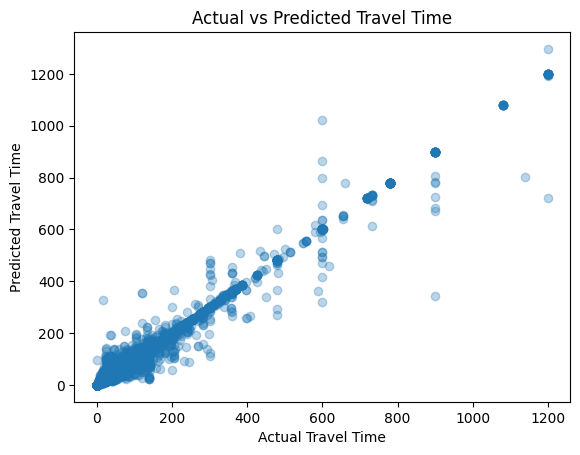

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Travel Time')
plt.ylabel('Predicted Travel Time')
plt.title('Actual vs Predicted Travel Time')
plt.show()


In [ ]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=200, random_state=42)

Mean Squared Error: 490.84576018002616


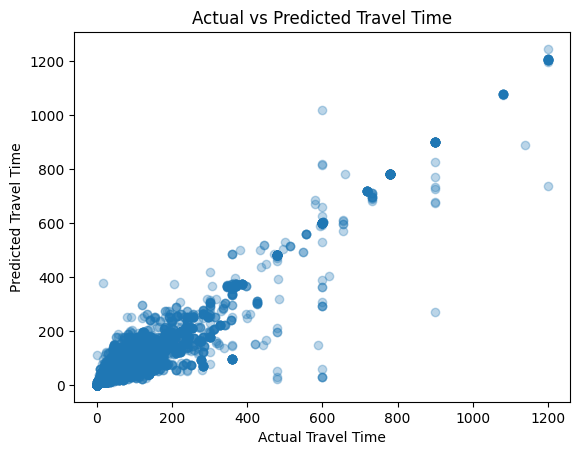

In [ ]:
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Travel Time')
plt.ylabel('Predicted Travel Time')
plt.title('Actual vs Predicted Travel Time')
plt.show()


-------

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)

stops_df = stops.copy()
stop_coords = stops_df[['stop_lat', 'stop_lon']].values

stops_df['cluster'] = kmeans.fit_predict(stop_coords)

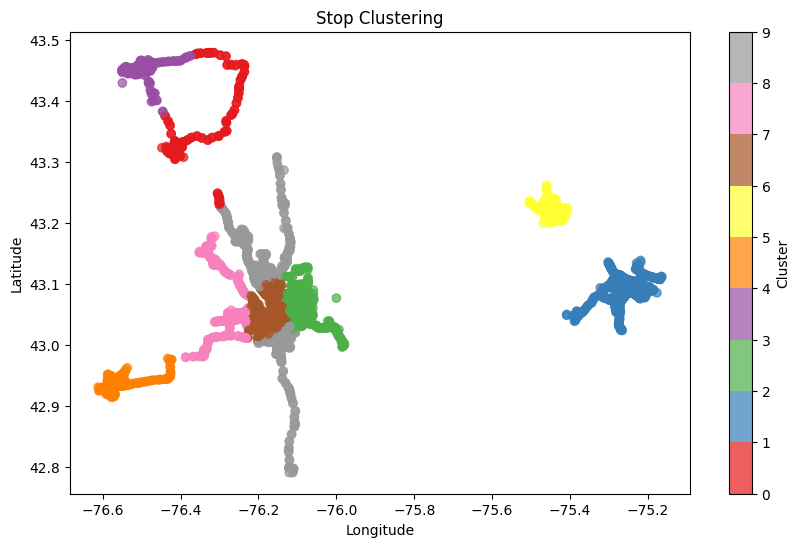

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(stops_df['stop_lon'], stops_df['stop_lat'],
                      c=stops_df['cluster'], cmap='Set1', alpha=0.7)

# Adding labels and title
plt.title('Stop Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(scatter, label='Cluster')

# Save the plot as an image (PNG format)
plt.savefig("stops_clusters_plot.png", bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
m = folium.Map(location=[stops_df['stop_lat'].mean(), stops_df['stop_lon'].mean()], zoom_start=14)

color_map = {
    0: 'blue',
    1: 'green',
    2: 'orange',
    3: 'red',
    4: 'purple',
    5: 'darkblue',
    6: 'darkgreen',
    7: 'darkorange',
    8: 'darkred',
    9: 'lightblue'
}

for idx, row in stops_df.iterrows():
    folium.Marker(
        location=[row['stop_lat'], row['stop_lon']],
        popup=row['stop_id'],
        icon=folium.Icon(color=color_map[row['cluster']])
    ).add_to(m)


for cluster in stops_df['cluster'].unique():
    cluster_stops = stops_df[stops_df['cluster'] == cluster]
    folium.Circle(
        location=[cluster_stops['stop_lat'].mean(), cluster_stops['stop_lon'].mean()],
        radius=50,  # Adjust radius as needed
        color=color_map[cluster],
        fill=True,
        fill_opacity=0.5,
        popup=f'Cluster {cluster}'
    ).add_to(m)

m.save("stops_clusters_map.html")

-------
-------
-------

In [ ]:
app = Flask(__name__)

# Define Datas



@app.route('/load_gtfs', methods=['POST'])
def load_gtfs():
    try:
        # Get the file path from the request
        file_path = request.json.get('file_path')
        path = Path(file_path)

        # Read GTFS feed
        feed = gk.read_feed(path, dist_units='km')

        # Process stop_times
        stop_times = feed.stop_times.copy()
        stop_times['arrival_time'] = stop_times['arrival_time'].str.replace(' ', '')
        stop_times['departure_time'] = stop_times['departure_time'].str.replace(' ', '')
        feed.stop_times = stop_times

        # Remove routes with no trips
        routes_with_no_trips = feed.trips['route_id'].unique()
        feed.routes = feed.routes[~feed.routes['route_id'].isin(routes_with_no_trips)]

        # Store processed data in session or return as needed
        routes = feed.routes.copy()
        shapes = feed.shapes.copy()
        stop_times = feed.stop_times.copy()
        stops = feed.stops.copy()
        trips = feed.trips.copy()

        return jsonify({
            'message': 'GTFS data loaded successfully',
            'routes_count': len(routes),
            'shapes_count': len(shapes),
            'stop_times_count': len(stop_times),
            'stops_count': len(stops),
            'trips_count': len(trips)
        }), 200

    except Exception as e:
        return jsonify({'error': str(e)}), 500


In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import gtfskit as gk
from pathlib import Path

app = Flask(__name__)

routes = None
shapes = None
stop_times = None
stops = None
trips = None

@app.route('/clean_data', methods=['GET'])
def clean_data():
    try:
        # Load the GTFS data
        path = Path('/content/gtfs-nyc-2023.zip')
        feed = gk.read_feed(path, dist_units='km')

        # Clean the stop_times data
        stop_times = feed.stop_times.copy()
        stop_times['arrival_time'] = stop_times['arrival_time'].str.replace(' ', '')
        stop_times['departure_time'] = stop_times['departure_time'].str.replace(' ', '')
        feed.stop_times = stop_times

        # Remove routes with no trips
        routes_with_no_trips = feed.trips['route_id'].unique()
        feed.routes = feed.routes[~feed.routes['route_id'].isin(routes_with_no_trips)]

        routes = feed.routes.copy()
        shapes = feed.shapes.copy()
        stop_times = feed.stop_times.copy()
        stops = feed.stops.copy()
        trips = feed.trips.copy()

        # Clean the arrival and departure times
        def clean_time(x):
            date = datetime.datetime.today()
            hr, min, sec = x.split(':')
            if x.startswith('24'):
                date = date + datetime.timedelta(days=1)
                hr = '00'
            x = f"{date.strftime('%Y-%m-%d')} {hr}:{min}:{sec}"
            return x

        stop_times['arrival_time'] = stop_times['arrival_time'].apply(clean_time)
        stop_times['departure_time'] = stop_times['departure_time'].apply(clean_time)

        # Convert to datetime
        stop_times['arrival_time'] = pd.to_datetime(stop_times['arrival_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        stop_times['departure_time'] = pd.to_datetime(stop_times['departure_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

        # Fill missing shape distances
        stop_times['shape_dist_traveled'] = stop_times['shape_dist_traveled'].fillna(0)

        # Clean routes and stops data
        routes = feed.routes[['route_id', 'route_long_name', 'route_type', 'route_color', 'route_text_color']]
        stops = feed.stops[['stop_id', 'stop_code', 'stop_name', 'stop_lat', 'stop_lon']]

        # Merge trips with routes
        trips = feed.trips.copy()
        trips_routes = trips.merge(routes, on='route_id', how='inner')

        # Merge stop times with trips
        stop_times_trips = stop_times.merge(trips_routes, on='trip_id', how='inner')

        # Group shapes and compute total distance
        shapes = feed.shapes.copy()
        shapes_grouped_lat_long = shapes.groupby('shape_id').apply(lambda x: list(zip(x['shape_pt_lat'], x['shape_pt_lon']))).reset_index().rename(columns={0: 'shape_points'})
        grouped_shapes = shapes_grouped_lat_long.merge(shapes.groupby('shape_id').agg(dist_traveled=('shape_dist_traveled', list)), on='shape_id', how='inner')
        grouped_shapes['total_dist_traveled'] = grouped_shapes['dist_traveled'].apply(lambda x: x[-1])

        # Merge trips with shapes
        trips_shapes = trips.merge(grouped_shapes, on='shape_id', how='inner')
        trips_shapes_routes = trips_shapes.merge(routes, on='route_id', how='inner')
        stop_times_trips_shapes = stop_times.merge(trips_shapes_routes, on='trip_id', how='inner')
        stop_times_trips_shapes_stops = stop_times_trips_shapes.merge(stops, on='stop_id', how='inner')

        # Return success message
        return jsonify({'message': 'GTFS data cleaned successfully!'}), 200

    except Exception as e:
        return jsonify({'error': str(e)}), 500


@app.route('/pareto_chart', methods=['GET'])
def pareto_chart():
    try:
        # Assuming routes_with_trips is already computed in your data loading process
        routes_with_trips = trips.groupby(by=['route_id']).agg(TotalTrips=('trip_id', 'count')).sort_values(by='TotalTrips', ascending=False).reset_index()


        # Create the Pareto chart
        fig = go.Figure()

        fig.add_trace(go.Bar(
            x=routes_with_trips['route_id'],
            y=routes_with_trips['TotalTrips'],
            name='Total Trips',
            marker_color='blue'
        ))

        fig.add_trace(go.Scatter(
            x=routes_with_trips['route_id'],
            y=routes_with_trips['cum_perc'],
            name='Cumulative Percentage',
            marker_color='red',
            yaxis='y2',
            mode='lines+markers'
        ))

        fig.add_trace(go.Scatter(
            x=routes_with_trips['route_id'],
            y=[80] * routes_with_trips.shape[0],
            yaxis='y2',
            mode='lines',
            line=dict(color='black', dash='dash'),
            name='80% Mark'
        ))

        fig.update_layout(
            title='Pareto Chart of Total Trips by Route',
            xaxis_title='Route ID',
            yaxis_title='Total Trips',
            yaxis2=dict(
                title='Cumulative Percentage',
                overlaying='y',
                side='right',
                range=[0, 100]
            ),
            barmode='overlay',
            legend=dict(x=0, y=1),
            showlegend=True
        )

        # Save the figure as an image (optional)
        fig.write_image("pareto_chart.png")  # Save to file
        return jsonify({'message': 'Pareto chart created successfully'}), 200

    except Exception as e:
        return jsonify({'error': str(e)}), 500





if __name__ == '__main__':
    app.run(debug=True)